## Predicting success of Redit post

In this excercise, we want to predict the score of reddit posts, using the labeled data (we assume the score is our target variable).
The data has different types of features that need to be handled differently. Due to lack of time and resources, a full analysis is not possible, but I have done a high-level analysis for this purpose.

I treat this problem as a Regression problem, where we are trying to predict the score of a Reddit post. We can also group the scores into 5 different buckets, and try to predict the "bucket" for each post (i.e. Very Low, Low, Med, High, Very High).


Installing and importing libraries:

In [ ]:
pip install sentence-transformers

In [24]:
pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.7 MB 2.9 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 3.7 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 0.7/390.2 MB 47.1 MB/s eta 0:00:09
   ---------------------------------------- 1.7/390.2 MB 21.3 MB/s eta 0:00:19
   ---------------------------------------- 2.4/390.2 MB 17.2 MB/s eta 0:00:23
   ---------------------------------------- 2.7/390.2 MB 19.3 MB/s eta 0:00:21
   ---------------------------------------- 3.8/390.2 MB 18.5 MB/s eta 0:00:21
   ---------------------------------------- 4.9/390.2 MB 17.3 MB/s eta 0:00:23
    ---------

  You can safely remove it manually.


In [ ]:
python3 -m pip install --upgrade 'optree>=0.13.0'

In [1]:
import os
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pandas as pd
# plot
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


# language model - BERT, use sentence transformer
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

C:\Users\alire\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [86]:
#Reading the data
df=pd.read_csv("askscience_data.csv")
df.head()

,Unnamed: 0,title,body,tag,datetime,author,score,upvote_ratio,url
0,0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...


Here we can see the data has text, date, score, numerical variable (upvote_ratio), etc. Let's look at attributes of the data:

In [7]:
df.shape

(4205, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4205 entries, 0 to 4204
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4205 non-null   int64  
 1   title         4205 non-null   object 
 2   body          2492 non-null   object 
 3   tag           4011 non-null   object 
 4   datetime      4205 non-null   object 
 5   author        4205 non-null   object 
 6   score         4205 non-null   float64
 7   upvote_ratio  4205 non-null   float64
 8   url           4205 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 295.8+ KB


In [10]:
df['title'].str.isspace().sum() #no titles with spaces

0

In [11]:
df['body'].str.isspace().sum() #body with spaces

2

In [16]:
#Whether there are blank bodies
df['body'].isna().sum()

1713

Here we can see that there are 1713 posts where the body of the post is blank (i.e. the post only has a title). There are many ways to treat this issue, such as removing the rows, using titles only for these rows, etc. But here, I will combine the title and the body into a new column called full_text, and will use this new column in the model (so I will not use body and text separately). The cons of this method is that the model may not be able to determine the important of body or text separately.

In [87]:
df['full_text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')
df

,Unnamed: 0,title,body,tag,datetime,author,score,upvote_ratio,url,full_text
0,0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...,Post viral cough: why does it get worse after ...
1,1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...,Can an x-ray of an adult show chronic malnouri...
2,2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...,[META] Bots and AI tools on r/askscience \n\n...
3,3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...,Can you predictably manipulate a magnetic gas?...
4,4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...,Are there cells in humans (or other mammals) t...
...,...,...,...,...,...,...,...,...,...,...
4200,795,I heard some electron microscopes use gallium....,NaN,Engineering,2022-01-12 17:14:35,Emma_Dale20,6.0,0.70,https://www.reddit.com/r/askscience/comments/s...,I heard some electron microscopes use gallium....
4201,796,is the spread of COVID typical for a respirato...,i understand that there's no respiratory virus...,COVID-19,2022-01-12 09:39:55,aggasalk,27.0,0.74,https://www.reddit.com/r/askscience/comments/s...,is the spread of COVID typical for a respirato...
4202,797,What is the technical difference between Cheek...,What are the technical difference(s) between t...,COVID-19,2022-01-12 14:47:28,h110hawk,3.0,0.67,https://www.reddit.com/r/askscience/comments/s...,What is the technical difference between Cheek...
4203,798,What starts the coagulation cascade during blo...,I understand that stasis of blood increases th...,Human Body,2022-01-12 14:20:26,joegoldbergg,5.0,0.78,https://www.reddit.com/r/askscience/comments/s...,What starts the coagulation cascade during blo...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4205 entries, 0 to 4204
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4205 non-null   int64  
 1   title         4205 non-null   object 
 2   body          2492 non-null   object 
 3   tag           4011 non-null   object 
 4   datetime      4205 non-null   object 
 5   author        4205 non-null   object 
 6   score         4205 non-null   float64
 7   upvote_ratio  4205 non-null   float64
 8   url           4205 non-null   object 
 9   full_text     4205 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 328.6+ KB


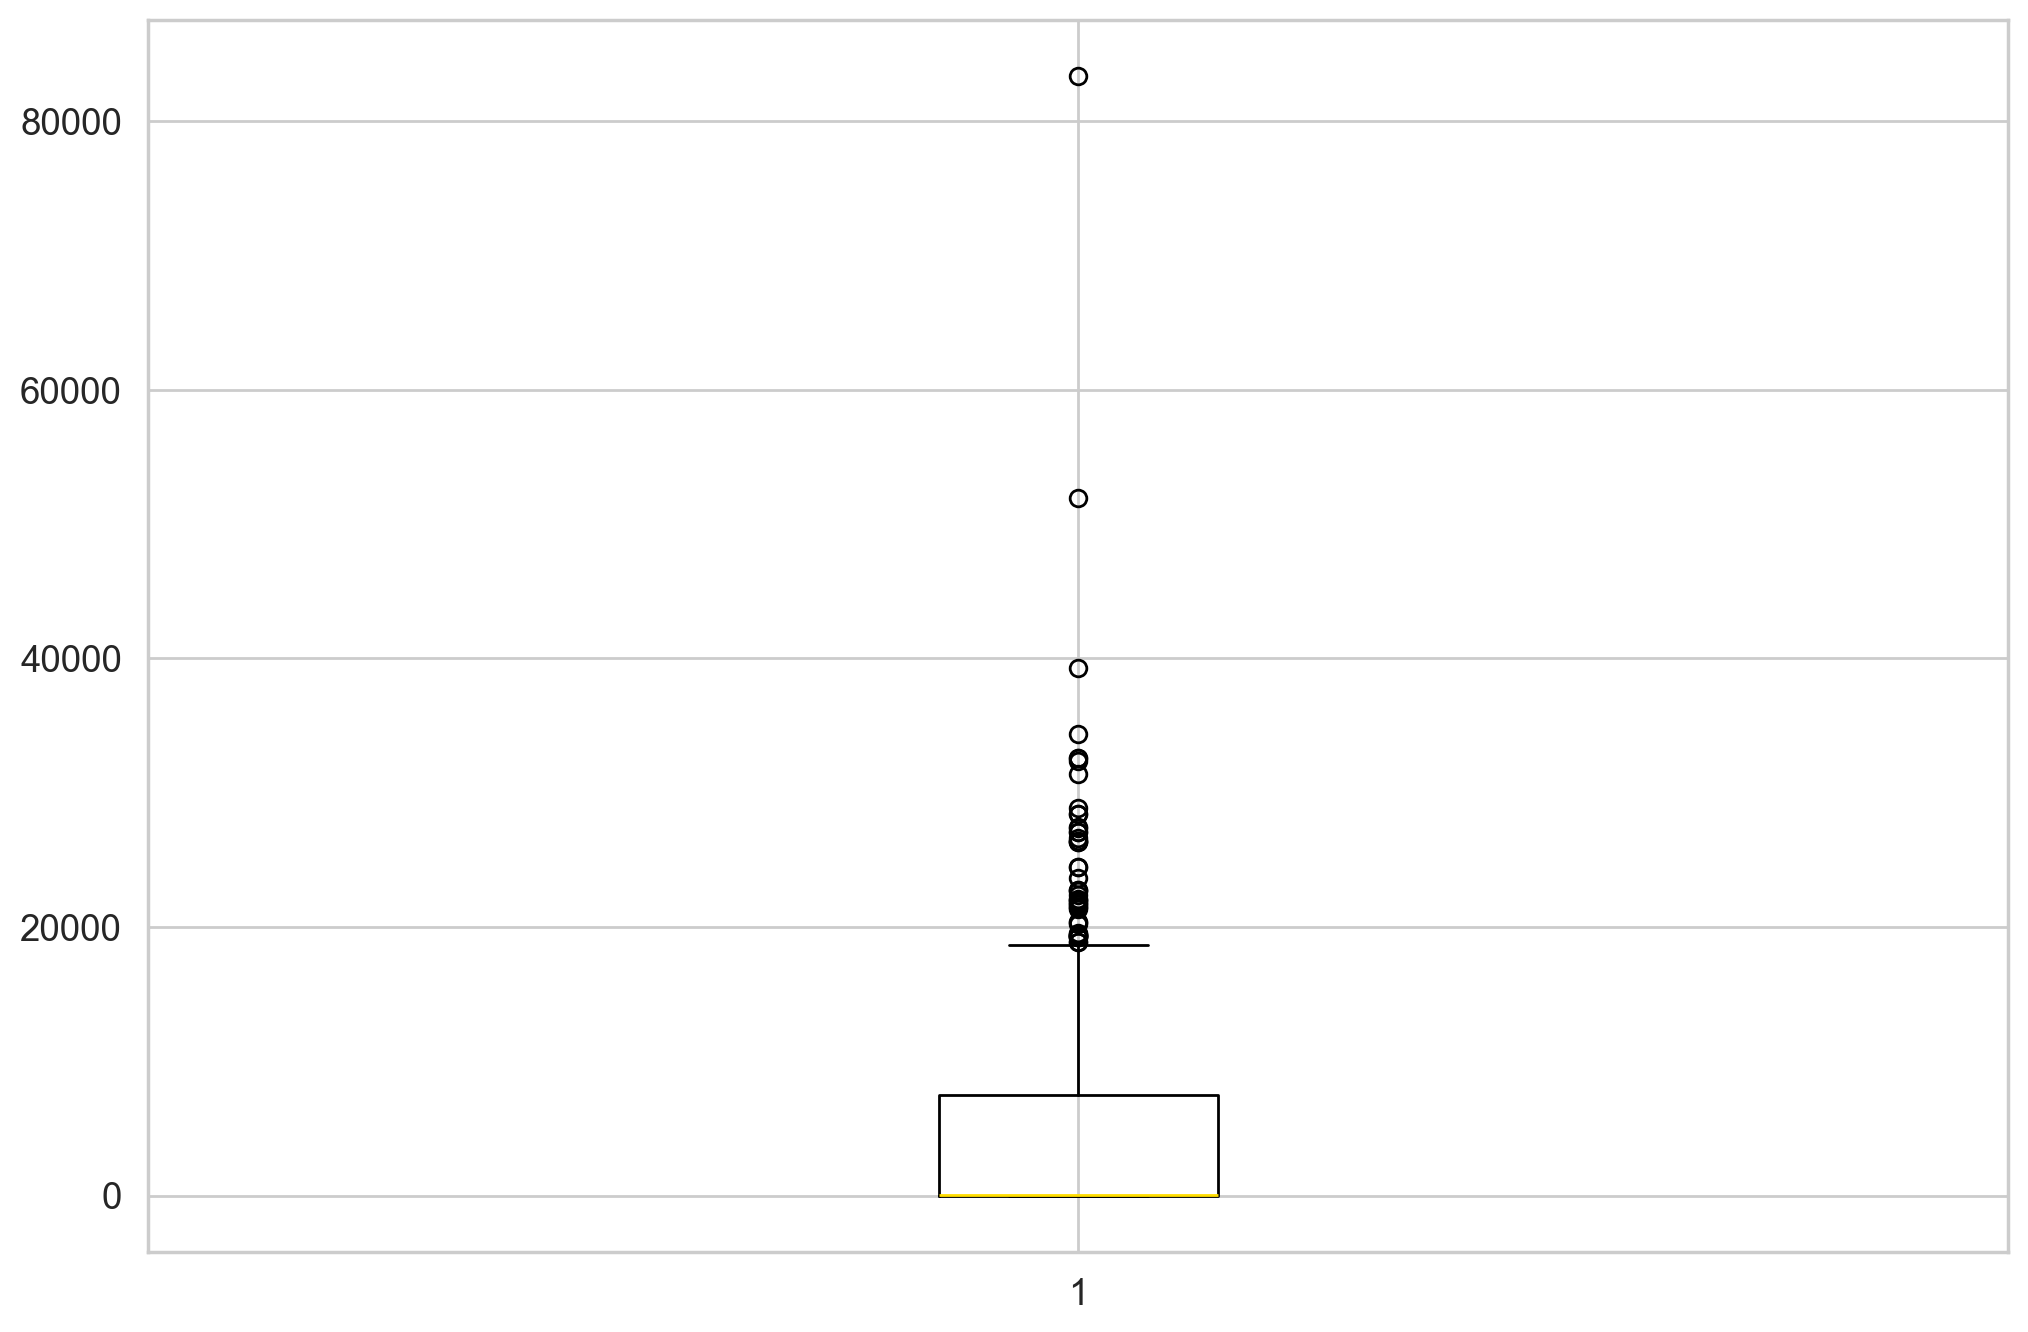

In [88]:
plt.boxplot(y_train)  # Check if `y` has outliers
plt.show()

There might be some outliers in the score, specially the ones that are above ~20000. Let's have a closer look at them:

In [89]:
df[df['score']>20000].shape[0]

51

A small percentage of the data (51/4205) have very large scores. So I will drop these rows

In [91]:
df=df[df['score']<20000]

In [92]:
df['author'].value_counts()

author
DELETED                244
AskScienceModerator     44
inquilinekea            12
PHealthy                 6
Toorelad                 6
                      ... 
Fit-Molasses4305         1
lgrey4252                1
derefr                   1
EremiticFerret           1
joegoldbergg             1
Name: count, Length: 3287, dtype: int64

The author data is sparse and specifically, DELETED authors has the highest number of occurances. Therefore, I will drop this column. Also, I wil dropped the first column (Unnamed: 0) and URL columns, as they do not provide usefull information to the model.

In [93]:
X = df.drop(columns=['score','Unnamed: 0','title','body','url','author'])
y = df['score']

In [94]:
X

,tag,datetime,upvote_ratio,full_text
0,Human Body,2022-12-09 02:52:07,0.93,Post viral cough: why does it get worse after ...
1,Human Body,2022-12-08 18:28:51,0.91,Can an x-ray of an adult show chronic malnouri...
2,META,2022-12-08 09:04:25,0.92,[META] Bots and AI tools on r/askscience \n\n...
3,Physics,2022-12-08 20:01:53,0.83,Can you predictably manipulate a magnetic gas?...
4,Medicine,2022-12-09 01:11:34,0.89,Are there cells in humans (or other mammals) t...
...,...,...,...,...
4200,Engineering,2022-01-12 17:14:35,0.70,I heard some electron microscopes use gallium....
4201,COVID-19,2022-01-12 09:39:55,0.74,is the spread of COVID typical for a respirato...
4202,COVID-19,2022-01-12 14:47:28,0.67,What is the technical difference between Cheek...
4203,Human Body,2022-01-12 14:20:26,0.78,What starts the coagulation cascade during blo...


In [95]:
X['tag'].value_counts()

tag
Biology                        714
Physics                        621
Human Body                     456
Medicine                       335
Earth Sciences                 311
Astronomy                      267
Chemistry                      228
COVID-19                       213
Engineering                    186
Planetary Sci.                 110
Neuroscience                   107
Mathematics                    102
Psychology                      90
Computing                       56
Paleontology                    47
Linguistics                     34
Anthropology                    21
Social Science                  18
Archaeology                     15
Economics                       14
Interdisciplinary                3
  Linguistics                    2
Earth Sciences and Biology       2
Ecology                          2
CERN AMA                         1
Dog Cognition AMA                1
Materials Science                1
First image of a black hole      1
Political Scienc

I will treat each variable type differently. 

1- For texts, I can use TF-IDF or BERT to embed them. Here I will be using BERT (but given more time, I would definately try other methods as well).

2- For categorial variable (tag), I will use one-hot encoding.

3- I will also convert datetime into separate day, week, etc features.

In [32]:
#importing BERT model

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\alire\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alire\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [96]:
text_column = 'full_text'  
categorical_column = 'tag' 
datetime_column = 'datetime'  
numerical_column = 'upvote_ratio'  
target_column = 'score' 

In [97]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday

In [98]:
#Treating categorial column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
tag_encoded = encoder.fit_transform(df[[categorical_column]])

In [99]:
#Treating text column
X_text_embedded = np.array([model.encode(text) for text in df['full_text']])

In [100]:
#Treating numerical column
scaler = StandardScaler()
numerical_features = df[[numerical_column, 'hour', 'day', 'month', 'weekday']]
X_numeric_scaled = scaler.fit_transform(numerical_features)

In [101]:
# Combine all features into final dataset
X_final = np.hstack((X_text_embedded, tag_encoded,X_numeric_scaled))
y = df[target_column]

In [102]:
X_final

array([[-0.00568251,  0.7802254 ,  0.2247732 , ..., -0.73023146,
         1.4820339 ,  0.48969435],
       [ 0.05821616,  0.77728862, -0.1449791 , ..., -0.84388382,
         1.4820339 , -0.00296497],
       [ 0.12916711,  0.57958782,  0.3642295 , ..., -0.84388382,
         1.4820339 , -0.00296497],
       ...,
       [-0.01103895,  0.96677649, -0.54587567, ..., -0.38927438,
        -1.3215288 , -0.49562429],
       [-0.16338892, -0.17184392,  0.50531566, ..., -0.38927438,
        -1.3215288 , -0.49562429],
       [ 1.01259363, -0.40983447,  0.72002631, ..., -0.50292674,
        -1.3215288 , -0.98828361]])

In [103]:
#splitting the data into train and test and creating a random forest model
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [104]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [108]:
y_pred = rf.predict(X_test)


In [110]:
print("Number of zeros in y_test:", (y_test == 0).sum())


Number of zeros in y_test: 91


Since there are zeros in the Score column, I will modify the MAPE function to account for this:

In [111]:
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100  # Avoid division by zero

mape = safe_mape(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAPE: 16389599682975.80%


It is observed that the MAPE value is very large and not acceptable. In the absence of time, I did not fully check the assumptions of regression, which needs to be done. There might be multicolinearity or heteroscedasticity, which need to be checked.

Also, outliers in other features need to be checked.